In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
tmdls = pd.read_csv('all_actions.csv', parse_dates=['TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(columns={'assessmentUnitIdentifier':'AUID'})
huc_npdes_permit_links = pd.read_csv('huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object}).rename(columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv('huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(columns={'attributes.assessmentunitidentifier':'AUID', 'attributes.huc12': 'HUC-12'})

In [126]:

AL_permit_dates = pd.read_csv('AL_permit_dates.csv', parse_dates=['effective_date', 'issue_date', 'original_effective_date', 'original_issue_date', 'expiration_date', 'retirement_date', 'termination_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

# Drop permits without an issue date
AL_permit_dates.dropna(subset='issue_date', inplace=True)

In [3]:
len(tmdls.drop_duplicates('actionIdentifier'))

20009

In [4]:
tmdls_merged = tmdls.drop_duplicates().merge(huc_AUID_links, on='AUID', how='inner').merge(huc_npdes_permit_links, on='HUC-12', how='inner')
del tmdls
del huc_AUID_links
del huc_npdes_permit_links

### Test state: Alabama

In [72]:
# Read in DMR data for limit comparisons
AL_dmrs = pd.read_csv('AL_dmrs.csv', parse_dates=['limit_begin_date', 'limit_end_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

In [148]:
# Extract only limits from DMR data
AL_limits = AL_dmrs.drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'limit_value_nmbr', 'statistical_base_code', 'limit_begin_date', 'version_nmbr'])

# Merge with `permit_dates` to get permit issuance date
AL_limits = AL_limits.merge(AL_permit_dates[['npdes_permit_id', 'version_nmbr', 'issue_date', 'expiration_date', 'retirement_date', 'termination_date']], on=['npdes_permit_id', 'version_nmbr'], how='left')
del AL_permit_dates

In [149]:
tmdls_merged_AL = tmdls_merged[tmdls_merged['state_code'] == 'AL']

In [150]:
tmdls_limits_merged = tmdls_merged_AL.merge(AL_limits, on='npdes_permit_id', how='inner')
tmdls_limits_merged = tmdls_limits_merged[~(tmdls_limits_merged['expiration_date'] <= tmdls_limits_merged['TMDLDate']) &
                                            ~(tmdls_limits_merged['retirement_date'] <= tmdls_limits_merged['TMDLDate']) &
                                            ~(tmdls_limits_merged['termination_date'] <= tmdls_limits_merged['TMDLDate'])]

In [151]:
len(tmdls_limits_merged)

487950

In [152]:
tmdls_limits_merged['incumbent'] = (tmdls_limits_merged['issue_date'] <= tmdls_limits_merged['TMDLDate'])

In [153]:
tmdls_limits_merged['incumbent'].value_counts()

False    327388
True     160562
Name: incumbent, dtype: int64

In [154]:
tmdls_limits_merged['pollutantName'].value_counts()

ESCHERICHIA COLI (E. COLI)      129572
TOTAL SUSPENDED SOLIDS (TSS)    125779
PHOSPHORUS, TOTAL               102392
PH                               41798
CARBONACEOUS BOD                 24124
NITROGENOUS BOD                  24124
FECAL COLIFORM                   23455
ALUMINUM                         13042
ENTEROCOCCUS BACTERIA             3545
LEAD                               119
Name: pollutantName, dtype: int64

In [155]:
params = tmdls_limits_merged['parameter_desc'].unique()
params.sort()
params

array(['%Effect Statre 48Hr Acute Ceriodaphnia',
       '%Effect Statre 48Hr Acute Pimephales', '.alpha.-Terpineol',
       '1,1,1-Trichloroethane', '1,1,2-Trichloroethane',
       '1,1-Dichloroethane', '1,1-Dichloroethylene',
       '1,2,4-Trichlorobenzene', '1,2-Dichlorobenzene',
       '1,2-Dichloroethane', '1,2-Dichloropropane', '1,3-Dichlorobenzene',
       '1,3-Dichloropropene', '1,4-Dichlorobenzene',
       '2,3,4,6-Tetrachlorophenol', '2,3,7,8-Tetrachlorodibenzo-p-dioxin',
       '2,3,7,8-Tetrachlorodibenzofuran', '2,4,5-Trichlorophenol',
       '2,4,6-Trichlorophenol', '2-Nitrophenol',
       '3,4,5-Trichlorocatechol', '3,4,5-Trichloroguaiacol',
       '3,4,6-Trichlorocatechol', '3,4,6-Trichloroguaiacol',
       '4,5,6-Trichloroguaiacol', '4,6-Dinitro-o-cresol', '4-Nitrophenol',
       'Acenaphthene', 'Acrylonitrile', 'Aluminum, total [as Al]',
       'Aluminum, total recoverable',
       'Ammonia [as N] + unionized ammonia',
       'Ammonia nitrogen, total, [as N] 30 day',
  

In [212]:
def plot_incumbent_comparison(data, parameter, bw=0.1):
    value_types = data['limit_value_type_code'].unique()
    fig, axes = plt.subplots(1, len(value_types), figsize=(15, 5))
    fig.suptitle(parameter + '\n (Orange=incumbent, Blue=newcomer)')
    for i in range(0, len(value_types)):
        sns.kdeplot(ax=axes[i], data=data[(data['incumbent']==True) & (data['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=bw, color='orange')
        sns.kdeplot(ax=axes[i], data=data[(data['incumbent']==False) & (data['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=bw)
        axes[i].set_title('Limit value type: ' + value_types[i] + ' (' + str(len(data[(data['incumbent']==True) & (data['limit_value_type_code']==value_types[i])])) + ' inc., ' + str(len(data[(data['incumbent']==False) & (data['limit_value_type_code']==value_types[i])])) + ' new)')

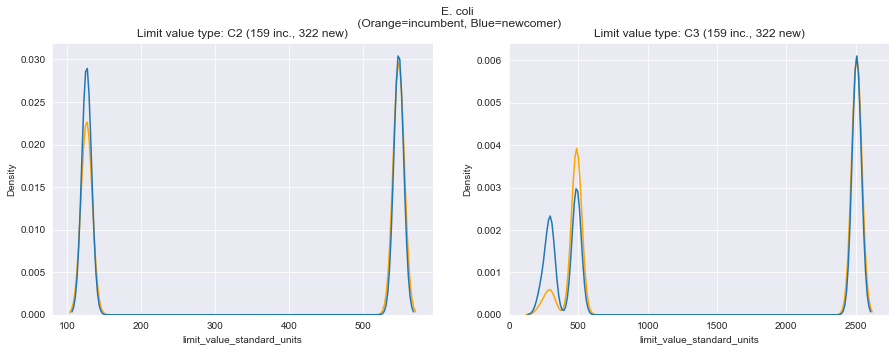

In [213]:
to_plot = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='ESCHERICHIA COLI (E. COLI)') & (tmdls_limits_merged['parameter_desc']=='E. coli')].dropna(subset='limit_value_standard_units')

plot_incumbent_comparison(to_plot, 'E. coli')

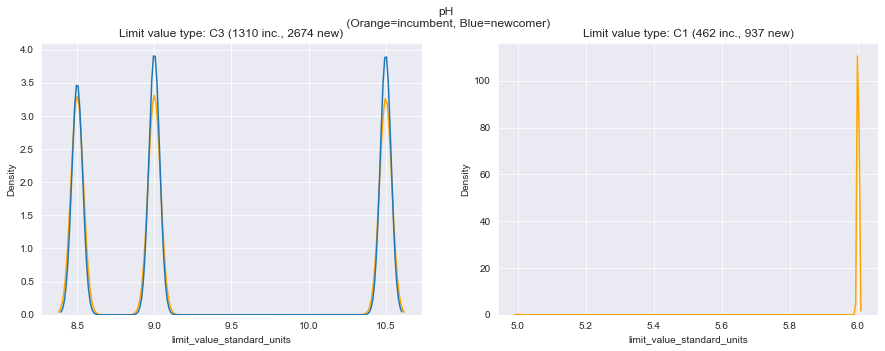

In [214]:
to_plot = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='PH') & (tmdls_limits_merged['parameter_desc']=='pH')].dropna(subset='limit_value_standard_units')

plot_incumbent_comparison(to_plot, 'pH', bw=0.2)

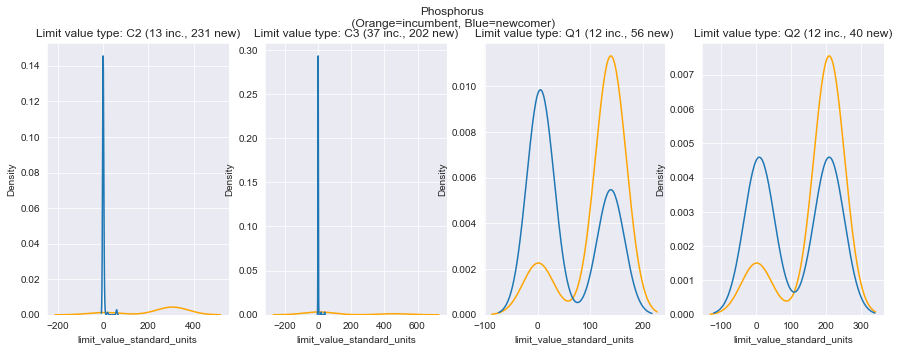

In [215]:
to_plot = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='PHOSPHORUS, TOTAL') & (tmdls_limits_merged['parameter_desc'].apply(lambda x: x in ['Phosphorus, Total As P', 'Phosphorus, total [as P]', 'Phosphorous, total elemental', 'Phosphorous, total organic [as P]', 'Phosphorous, total recoverable']))].dropna(subset='limit_value_standard_units')

plot_incumbent_comparison(to_plot, 'Phosphorus', bw=0.9)

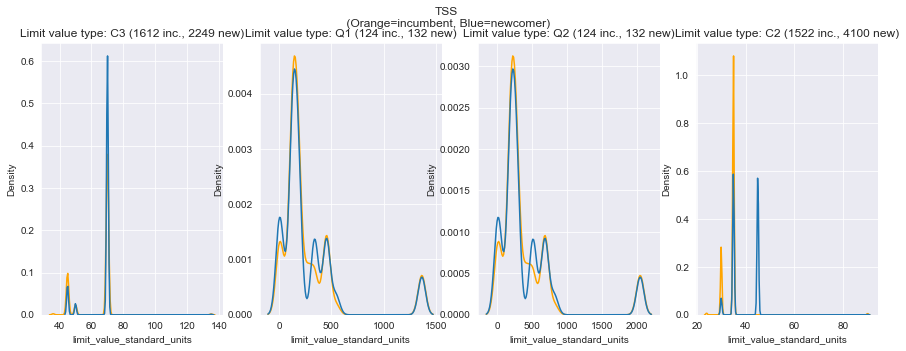

In [216]:
to_plot = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='TOTAL SUSPENDED SOLIDS (TSS)') & (tmdls_limits_merged['parameter_desc'] == 'Solids, total suspended')].dropna(subset='limit_value_standard_units')

plot_incumbent_comparison(to_plot, 'TSS', bw=0.3)